In [8]:
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html -q
#!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html -qqq

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from scipy.stats import rankdata
import torch
import time
from tqdm import tqdm
import random
import gc

In [4]:
import dgl
print(dgl.__path__)

['/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/dgl']


In [42]:

class GCN(torch.nn.Module):
    def __init__(self, in_dim, layer_num=3):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.activations = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        for i in range(layer_num):
            self.convs.append(
                dgl.nn.pytorch.conv.GraphConv(in_dim,in_dim,bias=False))
            self.activations.append(torch.nn.LeakyReLU())
        self.layer_num = layer_num
        self.out_dim = in_dim * (layer_num+1)
        
    def forward(self, g, h):
        hs = [h]
        for conv, act in zip(self.convs, self.activations):
            h = conv(g, h)
            h = act(h)
            hs.append(h)
        return torch.cat(hs, dim=-1)

class GNNModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout_rate=0.5):
        super(GNNModel, self).__init__()
        self.comp = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden_dim),
            torch.nn.LeakyReLU()
        )
        self.gcn = GCN(hidden_dim*2)
        self.dTm_head = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(self.gcn.out_dim*2, self.gcn.out_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(self.gcn.out_dim, 1),
        )
        self.ddG_head = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(self.gcn.out_dim*2, self.gcn.out_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(self.gcn.out_dim, 1),
        )
    
    def forward(self, g, wildtype_seq, mutation_seq, mutation_pos):
        wildtype_h = self.comp(wildtype_seq)
        mutation_h = self.comp(mutation_seq)
        cat_h = torch.cat([wildtype_h, mutation_h], dim=-1)
        
        cat_h = self.gcn(g, cat_h)
        
        with g.local_scope():
            g.ndata['h'] = cat_h
            cat_hg = dgl.readout_nodes(g, 'h', op='sum')
        
        mutation_pos = mutation_pos.float().unsqueeze(1)
        with g.local_scope():
            g.ndata['h'] = cat_h*mutation_pos
            cat_hp = dgl.readout_nodes(g, 'h', op='sum')
        
        h_all = torch.cat([cat_hg, cat_hp], dim=-1)
        
        pred_dTm = self.dTm_head(h_all)
        pred_ddG = self.ddG_head(h_all)
        
        return pred_dTm, pred_ddG

In [43]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, dir_path, indexes=None, add_self_loop=False):
        super(GraphDataset, self).__init__()
        self.dir_path = dir_path
        self.graphs, label_dict = dgl.load_graphs(self.dir_path+'/dgl_graph.bin')
        self.df = pd.read_csv(self.dir_path+'/overview_df.csv', index_col=0)
        self.add_self_loop = add_self_loop
        if indexes is None:
            self.indexes = self.df.index
        else:
            self.indexes = indexes

    def __getitem__(self, i):
        idx = self.indexes[i]
        
        row = self.df.loc[idx]
        
        graph_index = row.graph_index
        graph = self.graphs[graph_index].clone()
        if self.add_self_loop:
            graph = dgl.add_self_loop(graph)
        
        wildtype_feature = np.load(self.dir_path+'/'+row.wildtype_feature_path)
        wildtype_seq = wildtype_feature['wildtype_seq']
        
        mutation_feature = np.load(self.dir_path+'/'+row.mutation_feature_path)
        mutation_seq = mutation_feature['mutation_seq']
        mutation_pos = mutation_feature['mutation_pos']
        
        graph.ndata['wildtype_seq'] = torch.from_numpy(wildtype_seq)
        graph.ndata['mutation_seq'] = torch.from_numpy(mutation_seq)
        graph.ndata['mutation_pos'] = torch.from_numpy(mutation_pos)
        
        dTm = row.get('dTm', np.nan)
        dTm_valid = True
        if np.isnan(dTm):
            dTm_valid = False
         
        ddG = row.get('ddG', np.nan)
        ddG_valid = True
        if np.isnan(ddG):
            ddG_valid = False
        
        return graph, dTm, dTm_valid, ddG, ddG_valid, idx

    def __len__(self):
        return len(self.indexes)

In [44]:
def one_fold(train_indexes, val_indexes, cv_num=0):
    print(f'CV{cv_num}==================================')
    
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    dgl.seed(seed)
    
    #device = 'cuda'
    
    hidden_dim = 512
    epochs = 10
    batch_size = 16
    lr = 5e-5
    patience = 50
    weight_decay = 0.0
    
    train_dataset = GraphDataset('/scratch/madhu/ruchir/replica/train_dataset', train_indexes)
    train_dataloader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)#os.cpu_count())
    val_dataset = GraphDataset('/scratch/madhu/ruchir/replica/train_dataset', val_indexes)
    val_dataloader = dgl.dataloading.GraphDataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)#os.cpu_count())
    graph, dTm, dTm_valid, ddG, ddG_valid, original_index = next(iter(train_dataloader))
    feature_dim = graph.ndata['wildtype_seq'].shape[-1]
    model = GNNModel(feature_dim, hidden_dim)
    criterion = torch.nn.L1Loss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    st = time.time()
    min_val_loss = 1e5
    min_not_update_count = 0
    for epoch in range(epochs):
        all_dTm_loss = 0
        all_ddG_loss = 0
        dTm_count = 0
        ddG_count = 0
        model.train()
        for graph, dTm, dTm_valid, ddG, ddG_valid, original_index in tqdm(train_dataloader, leave=True):
            graph = graph
            dTm = dTm.float().unsqueeze(1)
            ddG = ddG.float().unsqueeze(1)
            wildtype_seq, mutation_seq, mutation_pos = graph.ndata['wildtype_seq'], graph.ndata['mutation_seq'], graph.ndata['mutation_pos']
            pred_dTm, pred_ddG = model(graph, wildtype_seq, mutation_seq, mutation_pos)
            dTm_loss = criterion(pred_dTm[dTm_valid], dTm[dTm_valid])
            ddG_loss = criterion(pred_ddG[ddG_valid], ddG[ddG_valid])
            loss = dTm_loss + ddG_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            all_dTm_loss += dTm_loss.item()
            all_ddG_loss += ddG_loss.item()
            dTm_count += dTm_valid.float().sum()
            ddG_count += ddG_valid.float().sum()
        train_dTm_loss = all_dTm_loss / dTm_count
        train_ddG_loss = all_ddG_loss / ddG_count
        train_all_loss = train_dTm_loss + train_ddG_loss

        all_dTm_loss = 0
        all_ddG_loss = 0
        dTm_count = 0
        ddG_count = 0
        model.eval()
        for graph, dTm, dTm_valid, ddG, ddG_valid, original_index in tqdm(val_dataloader, leave=True):
            graph = graph
            dTm = dTm.float().unsqueeze(1)
            ddG = ddG.float().unsqueeze(1)
            wildtype_seq, mutation_seq, mutation_pos = graph.ndata['wildtype_seq'], graph.ndata['mutation_seq'], graph.ndata['mutation_pos']
            with torch.no_grad():
                pred_dTm, pred_ddG = model(graph, wildtype_seq, mutation_seq, mutation_pos)
                dTm_loss = criterion(pred_dTm[dTm_valid], dTm[dTm_valid])
                ddG_loss = criterion(pred_ddG[ddG_valid], ddG[ddG_valid])
            all_dTm_loss += dTm_loss.item()
            all_ddG_loss += ddG_loss.item()
            dTm_count += dTm_valid.float().sum()
            ddG_count += ddG_valid.float().sum()
        val_dTm_loss = all_dTm_loss / dTm_count
        val_ddG_loss = all_ddG_loss / ddG_count
        val_all_loss = val_dTm_loss + val_ddG_loss
        spent_time = time.time() - st
        print(f'epoch: {epoch+1}  train_loss: {train_all_loss} train_dTm_loss: {train_dTm_loss} train_ddG_loss: {train_ddG_loss}')
        print(f'time: {np.around(spent_time/60, decimals=2)}min val_loss: {val_all_loss} val_dTm_loss: {val_dTm_loss} val_ddG_loss: {val_ddG_loss}')
        if val_ddG_loss <= min_val_loss:
            min_val_loss = val_ddG_loss
            min_not_update_count = 0
            torch.save(model.state_dict(),'best_model{cv_num}-p53.pt')
        else:
            min_not_update_count += 1
        if min_not_update_count > patience:
            print('Early stopping!')
            break
        if spent_time > 6000:
            print('timeover')
            break
    test_dataset = GraphDataset('/scratch/madhu/ruchir/replica/test_dataset')
    test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)#os.cpu_count())
    sub_df = test_dataset.df.copy()
    sub_df['ddG_pred'] = None
    model.load_state_dict(torch.load('best_model{cv_num}-p53.pt'))
    model.eval()
    for graph, dTm, dTm_valid, ddG, ddG_valid, original_index in test_dataloader:
        graph = graph
        wildtype_seq, mutation_seq, mutation_pos = graph.ndata['wildtype_seq'], graph.ndata['mutation_seq'], graph.ndata['mutation_pos']
        with torch.no_grad():
            pred_dTm, pred_ddG = model(graph, wildtype_seq, mutation_seq, mutation_pos)
        #pred = pred_dTm.cpu().numpy()
        pred = pred_ddG.cpu().numpy()
        original_index = original_index.numpy()
        sub_df.loc[original_index, 'ddG_pred'] = pred
    print(f'CV{cv_num} finish! min_val_loss={min_val_loss}')
    return sub_df[['index_b', 'ddG_pred']]

In [45]:
df = pd.read_csv('/scratch/madhu/ruchir/replica/train_dataset/overview_df.csv', index_col=0)
df=df[df['PDB'] !='2ocjA']

In [46]:
indexes = df.index
hasddG = df.loc[indexes, 'ddG'].isna().values
group = df.loc[indexes, 'graph_index'].values
skf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)
sub_df = None
column_names = []
for cv_num, (train, val) in enumerate(skf.split(indexes, hasddG, group)):
    train_indexes, val_indexes = indexes[train], indexes[val]
    column_name = f'ddG{cv_num}'
    cv_sub_df = one_fold(train_indexes, val_indexes, cv_num).rename(columns={'ddG_pred': column_name})
    column_names.append(column_name)
    if sub_df is None:
        sub_df = cv_sub_df
    else:
        sub_df = pd.merge(sub_df, cv_sub_df, on='index_b')
    gc.collect()

CV0==================================


 11%|█         | 46/423 [00:20<02:51,  2.19it/s]


KeyboardInterrupt: 

In [10]:
sub_df

,index_b,ddG0,ddG1
0,1bz6A_I28A,-0.500082,-0.578823
1,1bz6A_I28A,-0.500082,-0.578823
2,1bz6A_I28A,-0.500082,-0.578823
3,1bz6A_I28A,-0.500082,-0.578823
4,1bz6A_I28A,-0.500082,-0.578823
...,...,...,...
177,1bz6A_V68L,-0.379164,-0.2648
178,1bz6A_V68W,-0.379721,-0.211767
179,1bz6A_V68I,-0.226462,-0.170399
180,1bz6A_V68Y,-0.474819,-0.282914


In [11]:
sub_df_2=sub_df
#print(sub_df_2)
sub_df_2.set_index('index_b',inplace = True)
sub_df_2['ddG']= sub_df_2.mean(axis=1)
sub_df_2


,ddG0,ddG1,ddG
index_b,,,
1bz6A_I28A,-0.500082,-0.578823,-0.539453
1bz6A_I28A,-0.500082,-0.578823,-0.539453
1bz6A_I28A,-0.500082,-0.578823,-0.539453
1bz6A_I28A,-0.500082,-0.578823,-0.539453
1bz6A_I28A,-0.500082,-0.578823,-0.539453
...,...,...,...
1bz6A_V68L,-0.379164,-0.2648,-0.321982
1bz6A_V68W,-0.379721,-0.211767,-0.295744
1bz6A_V68I,-0.226462,-0.170399,-0.198431


In [12]:
#sub_df.to_csv('cv_submission.csv', index=False)

In [13]:
#for column_name in column_names:
#    sub_df[column_name] = rankdata(sub_df[column_name])
#sub_df['ddG'] = sub_df[column_names].mean(axis='columns')
#sub_df = sub_df[['index_b', 'ddG']]
#sub_df

In [14]:
sub_df.to_csv('submission_pre.csv', index=False)

In [15]:
sub_df_2 = sub_df_2.drop_duplicates()
sub_df_2=sub_df_2.groupby(by='index_b')
print(sub_df_2.mean())
sub_df_2=sub_df_2.mean()

                 ddG0      ddG1       ddG
index_b                                  
1bz6A_A125L  0.224669   0.07274  0.148705
1bz6A_A130K -0.397915  -0.27601 -0.336963
1bz6A_A130L -0.404888 -0.319322 -0.362105
1bz6A_A144L  0.134537  -0.01033  0.062103
1bz6A_A15L   0.179679  0.098292  0.138986
...               ...       ...       ...
1bz6A_V68T  -0.818974 -0.414949 -0.616962
1bz6A_V68W  -0.379721 -0.211767 -0.295744
1bz6A_V68Y  -0.474819 -0.282914 -0.378867
1bz6A_W14F  -0.627251 -0.732026 -0.679639
1bz6A_W7F   -0.065477 -0.350897 -0.208187

[113 rows x 3 columns]


In [16]:
sub_df_2=sub_df_2.reset_index()
sub_df_2.to_csv('submission.csv', index=False)

In [67]:
actual= pd.read_csv('/scratch/madhu/ruchir/replica/test_dataset/overview_df.csv', index_col=0)
actual.drop_duplicates(subset='index_b',inplace = True)
actual=actual.sort_values(by=['index_b'])
print(actual)

    Wildtype_Pdb  Position_mutant Wildtype Mutant   ddG  \
103        1bz6A              125        A      L -0.60   
74         1bz6A              130        A      K  3.70   
73         1bz6A              130        A      L  2.30   
104        1bz6A              144        A      L -0.40   
102        1bz6A               15        A      L -0.10   
..           ...              ...      ...    ...   ...   
46         1bz6A               68        V      T  1.67   
127        1bz6A               68        V      W  0.07   
130        1bz6A               68        V      Y  0.17   
88         1bz6A               14        W      F  1.10   
87         1bz6A                7        W      F  0.90   

                                      protein_sequence  graph_index  \
103  VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...            0   
74   VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...            0   
73   VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...            0   
104  VL

In [68]:
sub_df_2=pd.read_csv('submission.csv')

For myoglobin : 
Spearman's correlation coefficient: -0.5850349760105973
p-value: 1.0134727365166048e-11
RMSE: 1.7831994704016991
Pearson: -0.5710434933345676


/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

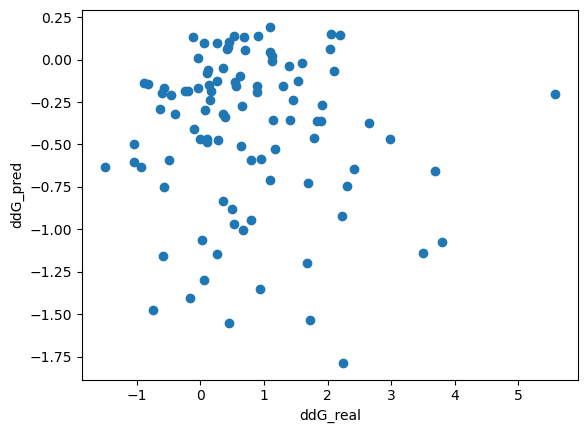

In [72]:
print("For myoglobin : ")
sub_df_2 = pd.read_csv('submission.csv')
from scipy.stats import spearmanr
# calculate Spearman's correlation coefficient and p-value
corr, pval = spearmanr(actual['ddG'],sub_df_2['ddG'] )
 
# print the result
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(actual['ddG'],sub_df_2['ddG'] , squared=False)
print("RMSE:", rms)
from scipy.stats import pearsonr
# Apply the pearsonr()
corr, _ = pearsonr(actual['ddG'],sub_df_2['ddG'] )
print("Pearson:", corr)

df = pd.DataFrame()
df["ddG_real"] = actual['ddG']
df["ddG_pred"] = sub_df_2['ddG']
import matplotlib.pyplot as plt
plt.scatter(data=df, x="ddG_real", y="ddG_pred")
plt.xlabel("ddG_real")
plt.ylabel("ddG_pred")
plt.savefig("GCN_myo_labels.jpg")

In [73]:
batch_size = 16
hidden_dim=512
test_dataset = GraphDataset('/scratch/madhu/ruchir/test_dataset_p53')
test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)#os.cpu_count())
sub_df = test_dataset.df.copy()
sub_df['ddG_pred'] = None

for graph, dTm, dTm_valid, ddG, ddG_valid, original_index in test_dataloader:
    graph = graph
    wildtype_seq, mutation_seq, mutation_pos = graph.ndata['wildtype_seq'], graph.ndata['mutation_seq'], graph.ndata['mutation_pos']
    feature_dim = graph.ndata['wildtype_seq'].shape[-1]
    model = GNNModel(feature_dim, hidden_dim)
    model.load_state_dict(torch.load('best_model{cv_num}-p53.pt'))
    model.eval()
    with torch.no_grad():
        pred_dTm, pred_ddG = model(graph, wildtype_seq, mutation_seq, mutation_pos)
        #pred = pred_dTm.cpu().numpy()
    pred = pred_ddG.cpu().numpy()
    original_index = original_index.numpy()
    sub_df.loc[original_index, 'ddG_pred'] = pred
sub_df_2=sub_df
sub_df_2=sub_df_2.rename(columns = {'M95T':'index_b'})
sub_df_2.set_index('index_b',inplace = True)
sub_df_2

,SET,CLUID,Wildtype_Pdb,ddG,Wildtype,Mutant,Position_mutant,protein_sequence,graph_index,mutation_feature_path,wildtype_feature_path,ddG_pred
index_b,,,,,,,,,,,,
Q104H,TEST_P53,2AC0A,2OCJA,0.24,Q,H,104,SVPSQKTYHGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTC...,0,mutation_feature_0.npz,wildtype_feature_0.npz,-0.184389
Q104P,TEST_P53,2AC0A,2OCJA,0.11,Q,P,104,SVPSQKTYPGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTC...,0,mutation_feature_1.npz,wildtype_feature_0.npz,-0.16276
T123A,TEST_P53,2AC0A,2OCJA,-0.13,T,A,123,SVPSQKTYQGSYGFRLGFLHSGTAKSVACTYSPALNKMFCQLAKTC...,0,mutation_feature_2.npz,wildtype_feature_0.npz,-0.183193
A129D,TEST_P53,2AC0A,2OCJA,-0.70,A,D,129,SVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPDLNKMFCQLAKTC...,0,mutation_feature_3.npz,wildtype_feature_0.npz,-0.339598
A129E,TEST_P53,2AC0A,2OCJA,-0.38,A,E,129,SVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPELNKMFCQLAKTC...,0,mutation_feature_4.npz,wildtype_feature_0.npz,-0.267122
A129S,TEST_P53,2AC0A,2OCJA,-0.19,A,S,129,SVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPSLNKMFCQLAKTC...,0,mutation_feature_5.npz,wildtype_feature_0.npz,-0.274569
M133L,TEST_P53,2AC0A,2OCJA,0.30,M,L,133,SVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKLFCQLAKTC...,0,mutation_feature_6.npz,wildtype_feature_0.npz,-0.740804
F134L,TEST_P53,2AC0A,2OCJA,-4.78,F,L,134,SVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMLCQLAKTC...,0,mutation_feature_7.npz,wildtype_feature_0.npz,-0.84715
V143A,TEST_P53,2AC0A,2OCJA,-3.50,V,A,143,SVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTC...,0,mutation_feature_8.npz,wildtype_feature_0.npz,-1.999437


In [74]:
sub_df_2=sub_df_2.reset_index()
sub_df_2.to_csv('submission_p53.csv', index=False)

For p53 : 
Spearman's correlation coefficient: 0.5199951383871935
p-value: 0.00041629845784808215
RMSE: 1.7903585600128735
Pearson: 0.6038805924325176


/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/madhu/.conda/envs/test3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

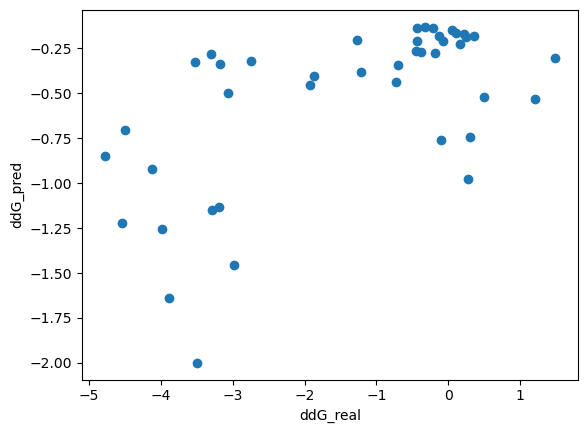

In [75]:
print("For p53 : ")
from scipy.stats import spearmanr
# calculate Spearman's correlation coefficient and p-value
corr, pval = spearmanr(sub_df_2['ddG'],sub_df_2['ddG_pred'] )
 
# print the result
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(sub_df_2['ddG'],sub_df_2['ddG_pred'] , squared=False)
print("RMSE:", rms)
from scipy.stats import pearsonr
# Apply the pearsonr()
corr, _ = pearsonr(sub_df_2['ddG'],sub_df_2['ddG_pred'] )
print("Pearson:", corr)

df = pd.DataFrame()
df["ddG_real"] = sub_df_2['ddG']
df["ddG_pred"] = sub_df_2['ddG_pred']
import matplotlib.pyplot as plt
plt.scatter(data=df, x="ddG_real", y="ddG_pred")
plt.xlabel("ddG_real")
plt.ylabel("ddG_pred")
plt.savefig("GCN_p53_labels.jpg")

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# 